# Hyperparameter Optimization of Momentum Strategies

By Joshua Batkhan (Spring 2021)

This notebook will take another look at the momentum strategies that were implemented in my blog last semester (check that out at https://www.smithinvestmentfund.com/blog/triple-momentum). We'll once again reintroduce the concepts of Relative, Dual, and Triple Momentum. If you need to jog your memory about these strategies, take a gander at the following brief summaries or check out the blog post linked above:

__Single (Relative) Momentum:__ Simply assessing which securities have the best momentum relative to their universe over the past some number of trading days.

__Dual (Absolute & Relative) Momentum:__ Adds a second screening that consists of checking whether the trend of the securities is positive (so of your X selected stocks, are they actually trending up, or are they trending down the least?)

__Triple (Macro) Momentum:__ Finally, this strategy adds yet another screening, which is about the macro-momentum of the universe. We want to check if the overall momentum of the universe is not generally declining before we buy.

Last time, I mentioned how each of these strategies has multiple parameters that could potentially be optimized. This time, our goal will be to do exactly that, utilizing the Ray Tune package to perform hyperparameter optimization on our Momentum strategies.

In [1]:
import logging
import datetime
import numpy as np
import pandas as pd
from hyperopt import hp
from ray import tune
import matplotlib.pyplot as plt
from sif.siftools.backtesters import full_backtesters as fb
from sif.sifinsights import alpha_search
from sif.sifinsights.alpha_search import apply_metric_func
from sif.sifinfra import sif_utils as su
from sif.siftools.abstractalpha import AbstractAlpha
from sif.siftools import operators as op, metrics
plt.rcParams['figure.figsize'] = (15, 9)

In [2]:
import warnings
warnings.filterwarnings('ignore')  # Disable warnings to reduce output spam in notebook

We split our entire dataset from 1/1/2003 to 1/1/2020, using the first 12 years as our in-sample data to optimize parameters and the remaining 5 years as our out-of-sample data to compare against our untested methods from last semester.

In [3]:
start_date = datetime.datetime(2003, 1, 1)
end_date = datetime.datetime(2014, 12, 31)
backtester = fb.FullMultipleBacktester(
    start_date,
    end_date,
    'Q',
    252,
    universe_size=500,
    factors=['close', 'sector', 'equity', 'netinc']

)
backtester.save_local('alpha_research_data_momentum_training.npy')
# backtester = fb.FullMultipleBacktester.from_local('alpha_research_data_2005.npy')

0

In [4]:
buffered_start_date = su.trading_days_to_date(backtester.start_date, backtester.max_lookback + backtester.delay, lookback=True)
sp_data = su.get_sp_close(buffered_start_date, backtester.end_date)
sp_ret = sp_data.pct_change(1)
backtester.add_factor(sp_data, 'sp_data')
print()

In [5]:
import numpy as np
def equal_long(factor):
    long_mask = factor != 0
    weights = np.zeros_like(factor)
    weights[long_mask] = 1. / long_mask.sum()
    return weights

In order to optimize, we first import our strategies from last time. We then peform tuning on three different parameters for Relative momentum in our in-sample period: lookback time (`t`), time between re-checks of momentum (`locklen`), and finally the threshold for what top percentage of stocks we consider in our long-only portfolio (`zscore`). We then run 1,000 trials and pick the values that generate the greatest revenue.

In [6]:
from examples.triplemomentum_alpha import RelativeMomentum

In [7]:
space = {'t': tune.randint(100, 250), 'locklen': tune.sample_from(lambda spec: tune.randint(1, spec.config.t)), 'zscore': tune.quniform(1.5, 2.6, 0.01)}
relative_result = alpha_search.tune_search(RelativeMomentum, backtester, 'return', space, 1000, algo='random', store_results=False, seed=42, verbose=1)

2021-04-25 22:54:25,725	INFO tune.py:450 -- Total run time: 2298.22 seconds (2271.23 seconds for the tuning loop).


In [8]:
print(relative_result)
relative_params = relative_result.best_params

This search result contains 100 trials across 3 parameters
The best alpha achieved a score of 2.2552633966965843 on trial 57 with parameters: {'t': 167, 'locklen': 65, 'zscore': 2.35}
The following parameter importances are calculated using a relative weights analysis:
{'param_t': 0.011886247983694023, 'param_locklen': 0.9199580964382108, 'param_zscore': 0.06815565557809482}


We continue with Dual Momentum, adding two additional parameters to consider in our optimization trials. First is a filter of stocks with a percent loss of (`buffer`) or greater since the last evaluation period. And second is a filter of stocks with a percent loss of (`stoploss`) or greater over the `locklen` period.

In [9]:
from examples.triplemomentum_alpha import DualMomentum

In [10]:
space = {'t': tune.randint(100, 250), 'locklen': tune.sample_from(lambda spec: tune.randint(1, spec.config.t)), 'zscore': tune.quniform(1.5, 2.6, 0.01), 'buffer': tune.quniform(-0.1, -0.01, 0.005), 'stoploss': tune.quniform(-0.2, -0.01, 0.01)}
dual_result = alpha_search.tune_search(DualMomentum, backtester, 'return', space, 1000, algo='random', store_results=False, seed=42, verbose=1)

2021-04-25 23:32:53,355	INFO tune.py:450 -- Total run time: 2306.46 seconds (2300.41 seconds for the tuning loop).


In [11]:
print(dual_result)
dual_params = dual_result.best_params

This search result contains 100 trials across 5 parameters
The best alpha achieved a score of 2.3056014000703913 on trial 1 with parameters: {'t': 240, 'locklen': 68, 'zscore': 2.57, 'buffer': -0.02, 'stoploss': -0.13}
The following parameter importances are calculated using a relative weights analysis:
{'param_t': 0.25916372618307987, 'param_locklen': 0.2677282120942752, 'param_zscore': 0.3029673676288981, 'param_buffer': 0.014127159112774733, 'param_stoploss': 0.15601353498097334}


Finally we have Triple Momentum, where we introduce yet another two parameters. First is how many days we want the lookback for the entire S&P500 to be (`macrolen`). Finally, we have how big of a percentage drop we require to sell all our assests (`macroratio`).

In [12]:
from examples.triplemomentum_alpha import TripleMomentum

In [13]:
space = {'t': tune.randint(100, 250), 'locklen': tune.sample_from(lambda spec: tune.randint(1, spec.config.t)), 'zscore': tune.quniform(1.5, 2.6, 0.01), 'buffer': tune.quniform(-0.1, -0.01, 0.005), 'stoploss': tune.quniform(-0.2, -0.01, 0.01), 'macrolen': tune.sample_from(lambda spec: tune.randint(150, 2*spec.config.t)), 'macroratio': tune.quniform(0.02, 0.10, 0.01)}
triple_result = alpha_search.tune_search(TripleMomentum, backtester, 'return', space, 1000, algo='random', store_results=False, seed=42, verbose=1)

2021-04-26 00:14:37,129	INFO tune.py:450 -- Total run time: 2502.66 seconds (2495.62 seconds for the tuning loop).


In [14]:
print(triple_result)
triple_params = triple_result.best_params

This search result contains 100 trials across 7 parameters
The best alpha achieved a score of 2.8870514987055453 on trial 0 with parameters: {'t': 195, 'locklen': 182, 'zscore': 2.15, 'buffer': -0.1, 'stoploss': -0.07, 'macrolen': 217, 'macroratio': 0.07}
The following parameter importances are calculated using a relative weights analysis:
{'param_t': 0.5752251429979947, 'param_locklen': 0.020342420745472333, 'param_zscore': 0.01910775230075733, 'param_buffer': 0.05774577164547539, 'param_stoploss': 0.02210863688252214, 'param_macrolen': 0.04623105877991787, 'param_macroratio': 0.2592392166478605}


Now we test on our remaining data out-of-sample to compare pre-optimized strategies to newly optimized strategies.

In [15]:
start_date = datetime.datetime(2015, 1, 1)
end_date = datetime.datetime(2020, 1, 1)
testing = fb.FullMultipleBacktester(
    start_date,
    end_date,
    'Q',
    252,
    universe_size=500,
    factors=['close', 'sector', 'equity', 'netinc']

)
testing.save_local('alpha_research_data_momentum_testing.npy')
# backtester = fb.FullMultipleBacktester.from_local('alpha_research_data_2005.npy')

0

In [16]:
buffered_start_date = su.trading_days_to_date(testing.start_date, testing.max_lookback + testing.delay, lookback=True)
sp_data = su.get_sp_close(buffered_start_date, testing.end_date)
sp_ret = sp_data.pct_change(1)
testing.add_factor(sp_data, 'sp_data')
print()

We make a distinction between the new and old momentum strategies. Note that the ideas behind the strategies remain the same; the only differences between the old and new are that the "new" strategies feature the optimized values for parameters obtained above, while the "old" strategies have the same arbitrary values that were chosen in the previous blog post.

In [17]:
class RelativeMomentum_OLD(AbstractAlpha):
    def __init__(self):
        self.name = 'RelativeMomentum_OLD'
        self.lookback = 160
        self.universe_size = 500
        self.factor_list = ['close', 'sector']
        self.holdings_lock = None

    def generate_day(self, day, data):   
        lock_len = 15
        
        if self.lock_holdings(lock_len):
            close = data['close']
            momentum = op.rank(op.group_zscore(close[day] / close[day - self.lookback] - 1, data['sector']))
            gain = op.group_zscore(close[day] / close[day - self.lookback] - 1 , data['sector'])
            factor = op.group_zscore(momentum, data['sector'])
            factor[gain <= 1.96] = 0
            self.weights = equal_long(factor)
            return self.weights
    
        else:
            return self.weights
        
class RelativeMomentum_NEW(AbstractAlpha):
    def __init__(self):
        self.name = 'RelativeMomentum_NEW'
        self.lookback = relative_params.get("t")
        self.universe_size = 500
        self.factor_list = ['close', 'sector']
        self.holdings_lock = None

    def generate_day(self, day, data):   
        lock_len = relative_params.get("locklen")
        
        if self.lock_holdings(lock_len):
            close = data['close']
            momentum = op.rank(op.group_zscore(close[day] / close[day - self.lookback] - 1, data['sector']))
            gain = op.group_zscore(close[day] / close[day - self.lookback] - 1 , data['sector'])
            factor = op.group_zscore(momentum, data['sector'])
            factor[gain <= relative_params.get("zscore")] = 0
            self.weights = equal_long(factor)
            return self.weights
    
        else:
            return self.weights

In [43]:
class DualMomentum_OLD(AbstractAlpha):
    def __init__(self):
        self.name = 'DualMomentum_OLD'
        self.lookback = 160
        self.universe_size = 500
        self.factor_list = ['close', 'sector']
        self.holdings_lock = None

    def generate_day(self, day, data):
        lock_len = 15
        
        if self.lock_holdings(lock_len):
            close = data['close']
            momentum = op.rank(op.group_zscore(close[day] / close[day - self.lookback] - 1, data['sector']))
            gain = op.group_zscore(close[day] / close[day - self.lookback] - 1 , data['sector'])
            abs_gain = close[day] / close[day - self.lookback] - 1
            recency_check = close[day] / close[day - lock_len] - 1
            
            factor = op.group_zscore(momentum, data['sector'])
            factor[gain <= 1.96] = 0
            factor[abs_gain <= -0.03] = 0
            factor[recency_check <= -0.08] = 0
            self.weights = equal_long(factor)
            return self.weights
        else:
            return self.weights
        
class DualMomentum_NEW(AbstractAlpha):
    def __init__(self):
        self.name = 'DualMomentum_NEW'
        self.lookback = dual_params.get("t")
        self.universe_size = 500
        self.factor_list = ['close', 'sector']
        self.holdings_lock = None

    def generate_day(self, day, data):
        lock_len = dual_params.get("locklen")
        
        if self.lock_holdings(lock_len):
            close = data['close']
            momentum = op.rank(op.group_zscore(close[day] / close[day - self.lookback] - 1, data['sector']))
            gain = op.group_zscore(close[day] / close[day - self.lookback] - 1 , data['sector'])
            abs_gain = close[day] / close[day - self.lookback] - 1
            recency_check = close[day] / close[day - lock_len] - 1
            
            factor = op.group_zscore(momentum, data['sector'])
            factor[gain <= dual_params.get("zscore")] = 0
            factor[abs_gain <= dual_params.get("buffer")] = 0
            factor[recency_check <= dual_params.get("stoploss")] = 0
            self.weights = equal_long(factor)
            return self.weights
        else:
            return self.weights

In [45]:
class TripleMomentum_OLD(AbstractAlpha):
    def __init__(self):
        self.name = 'TripleMomentum_OLD'
        self.lookback = 160
        self.universe_size = 500
        self.factor_list = ['close', 'sector', 'sp_data']
        self.holdings_lock = None

    def generate_day(self, day, data):
        lock_len = 15
        macro_len = 200
        macro_ratio = 0.04
        
        close = data['close']
        sp_index = data['sp_data']
        momentum = op.rank(op.group_zscore(close[day] / close[day - self.lookback] - 1, data['sector']))
        
        if self.lock_holdings(lock_len):
            if sp_index[day] / sp_index[day - macro_len] <= 1-macro_ratio:
                momentum[:] = 0
                factor = op.group_zscore(momentum, data['sector'])
                
            else:
                gain = op.group_zscore(close[day] / close[day - self.lookback] - 1 , data['sector'])
                abs_gain = close[day] / close[day - self.lookback] - 1
                recency_check = close[day] / close[day - lock_len] - 1
                
                factor = op.group_zscore(momentum, data['sector'])
                factor[gain <= 1.96] = 0
                factor[abs_gain <= -0.03] = 0
                factor[recency_check <= -0.08] = 0
                
            self.weights = equal_long(factor)
            return self.weights
        
        else:
            return self.weights
        
class TripleMomentum_NEW(AbstractAlpha):
    def __init__(self):
        self.name = 'TripleMomentum_NEW'
        self.lookback = triple_params.get("t")
        self.universe_size = 500
        self.factor_list = ['close', 'sector', 'sp_data']
        self.holdings_lock = None

    def generate_day(self, day, data):
        lock_len = triple_params.get("locklen")
        macro_len = triple_params.get("macrolen")
        macro_ratio = triple_params.get("macroratio")
        
        close = data['close']
        sp_index = data['sp_data']
        momentum = op.rank(op.group_zscore(close[day] / close[day - self.lookback] - 1, data['sector']))
        
        if self.lock_holdings(lock_len):
            if sp_index[day] / sp_index[day - macro_len] <= 1-macro_ratio:
                momentum[:] = 0
                factor = op.group_zscore(momentum, data['sector'])
                
            else:
                gain = op.group_zscore(close[day] / close[day - self.lookback] - 1 , data['sector'])
                abs_gain = close[day] / close[day - self.lookback] - 1
                recency_check = close[day] / close[day - lock_len] - 1
                
                factor = op.group_zscore(momentum, data['sector'])
                factor[gain <= triple_params.get("zscore")] = 0
                factor[abs_gain <= triple_params.get("buffer")] = 0
                factor[recency_check <= triple_params.get("stoploss")] = 0
                
            self.weights = equal_long(factor)
            return self.weights
        
        else:
            return self.weights

Now we perform backtesting for each of our Alpha strategies.

In [47]:
alphas =  [
    RelativeMomentum_OLD(),
    DualMomentum_OLD(),
    TripleMomentum_OLD(),
    RelativeMomentum_NEW(),
    DualMomentum_NEW(),
    TripleMomentum_NEW()
    ]
returns, holdings = testing.backtest(alphas, processes=None)

alphasRelative = [
    RelativeMomentum_OLD(),
    RelativeMomentum_NEW(),
    ]
returnsRelative, holdingsRelative = testing.backtest(alphasRelative, processes=None)

alphasDual =  [
    DualMomentum_OLD(),
    DualMomentum_NEW(),
    ]
returnsDual, holdingsDual = testing.backtest(alphasDual, processes=None)

alphasTriple =  [
    TripleMomentum_OLD(),
    TripleMomentum_NEW()
    ]
returnsTriple, holdingsTriple = testing.backtest(alphasTriple, processes=None)

TripleMomentum_NEW: 100%|██████████| 2/2 [00:25<00:00, 12.88s/it]


We need to fix the dimensions of S&P500 data before we can do any plotting (note that we had a buffered start date for this data earlier, which is why we need to do this).

In [24]:
sp_data = su.get_sp_close(start_date, end_date)
sp_ret = sp_data.pct_change()

We first compare the cumulative returns of _all_ the strategies against each other and the S&P. We then look at individual strategies before and after optimization against each other and the S&P.

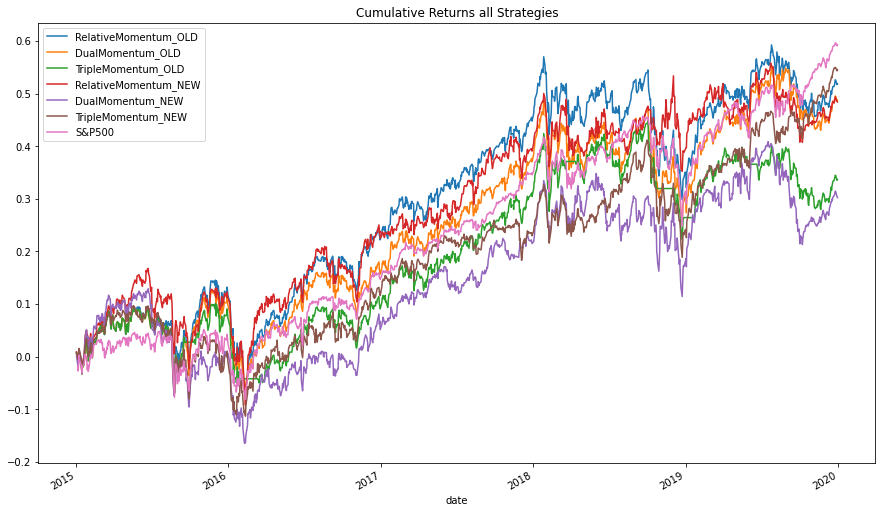

In [49]:
returns.cumsum().plot()
sp_ret.cumsum().plot(label='S&P500')
plt.legend(labels=['RelativeMomentum_OLD', 'DualMomentum_OLD', 'TripleMomentum_OLD', 'RelativeMomentum_NEW', 'DualMomentum_NEW', 'TripleMomentum_NEW','S&P500'])
plt.title('Cumulative Returns all Strategies')
plt.show()

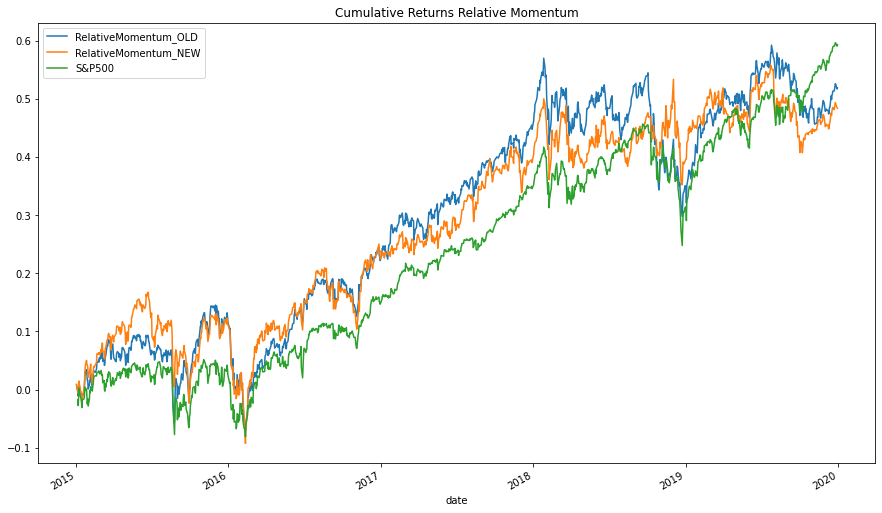

In [39]:
returnsRelative.cumsum().plot()
sp_ret.cumsum().plot(label='S&P500')
plt.legend(labels=['RelativeMomentum_OLD', 'RelativeMomentum_NEW', 'S&P500'])
plt.title('Cumulative Returns Relative Momentum')
plt.show()

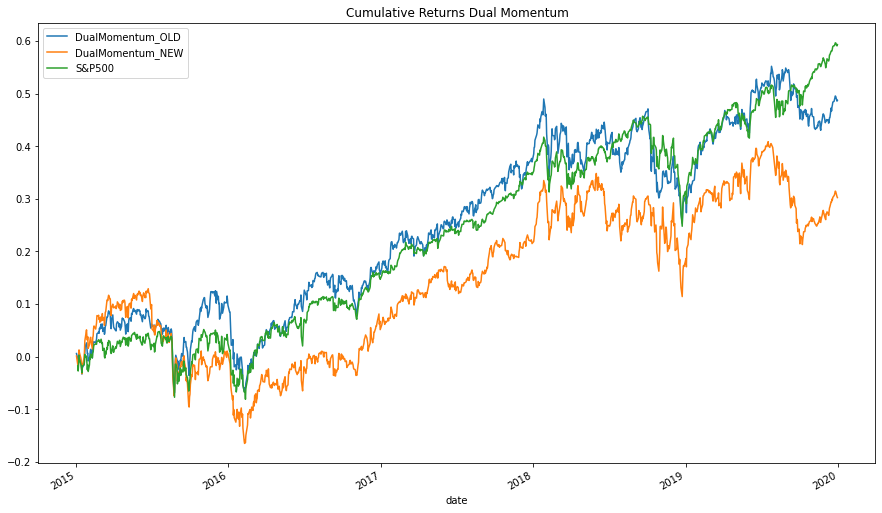

In [40]:
returnsDual.cumsum().plot()
sp_ret.cumsum().plot(label='S&P500')
plt.legend(labels=['DualMomentum_OLD', 'DualMomentum_NEW', 'S&P500'])
plt.title('Cumulative Returns Dual Momentum')
plt.show()

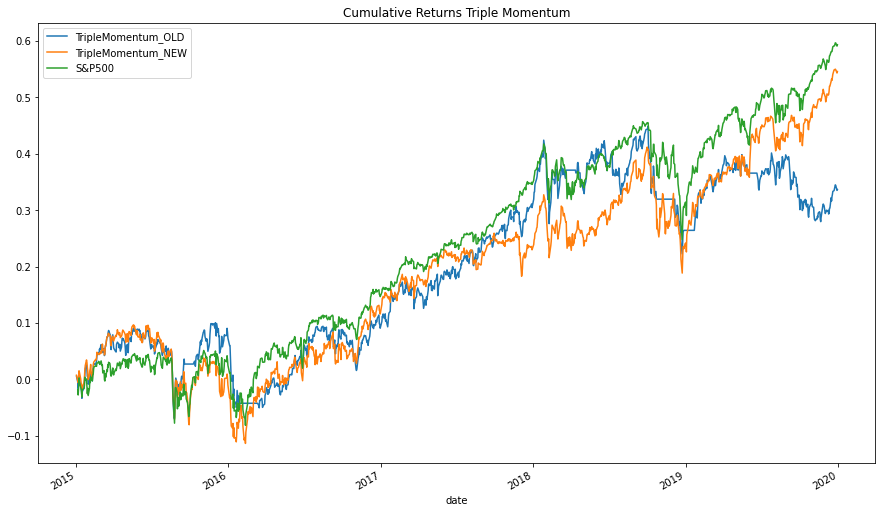

In [41]:
returnsTriple.cumsum().plot()
sp_ret.cumsum().plot(label='S&P500')
plt.legend(labels=['TripleMomentum_OLD', 'TripleMomentum_NEW','S&P500'])
plt.title('Cumulative Returns Triple Momentum')
plt.show()

We create summary plots of the optimized strategies so we can see how they vary individually over time.

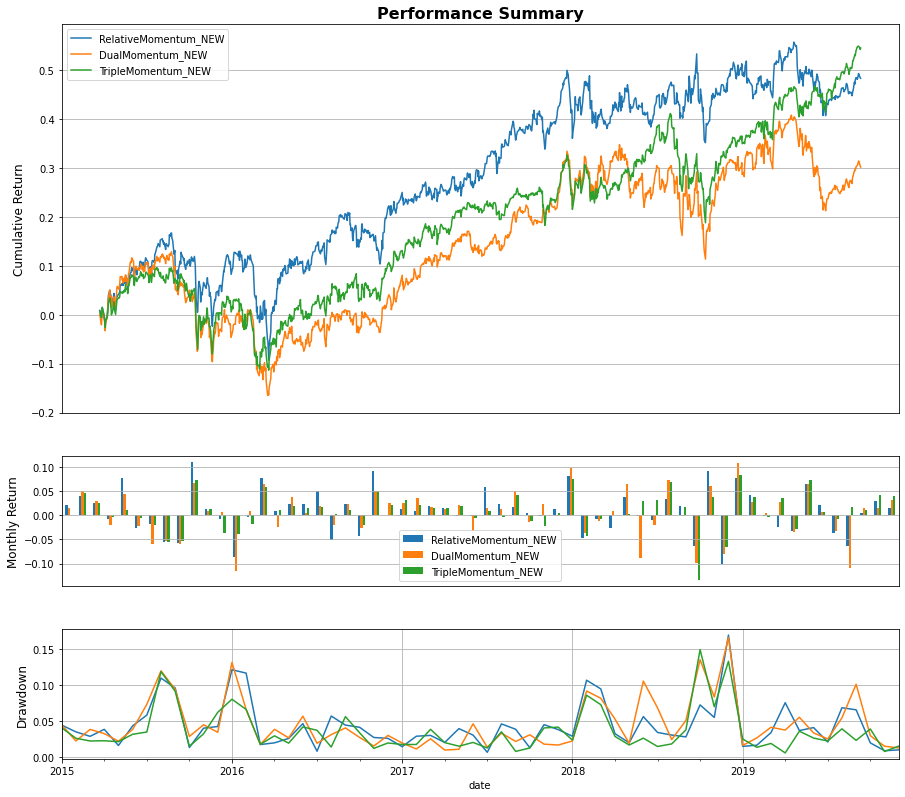

In [48]:
metrics.summary_plot(returns[['RelativeMomentum_NEW', 'DualMomentum_NEW', 'TripleMomentum_NEW']], source=['RelativeMomentum_NEW', 'DualMomentum_NEW', 'TripleMomentum_NEW'])

We use `apply_metric_func` from `alpha_eval` and `generate_performance_table` from `metrics` to produce a summary analytics for each strategy, to more closely compare their performance.

In [50]:
from IPython.core import display as ICD
perf_tables = apply_metric_func(metrics.generate_performance_table, ('daily_returns', 'holdings'))(returns, holdings)
for alpha, table in zip(alphas, perf_tables):
    print(f"{alpha.name}")
    ICD.display(table)
    print()

RelativeMomentum_OLD


,return,sharpe,sortino,drawdown,turnover,long count,short count
year,,,,,,,
2015,0.116243,0.704044,0.984518,0.143600,0.049925,22.559524,0.0
2016,0.105550,0.674747,0.898492,0.165506,0.069307,17.904762,0.0
2017,0.225773,1.780128,2.243799,0.047493,0.066745,21.764940,0.0
2018,-0.096973,-0.424223,-0.529024,0.256866,0.061458,19.836653,0.0
2019,0.168051,1.073864,1.510177,0.131600,0.061964,19.563492,0.0
Overall,0.518644,0.609459,0.772394,0.256866,0.087756,20.325119,0.0



DualMomentum_OLD


,return,sharpe,sortino,drawdown,turnover,long count,short count
year,,,,,,,
2015,0.097615,0.600057,0.846402,0.150996,0.056933,21.404762,0.0
2016,0.058871,0.403999,0.536639,0.154375,0.076688,17.035714,0.0
2017,0.213550,1.657280,2.056916,0.052082,0.071378,21.027888,0.0
2018,-0.066244,-0.305547,-0.374377,0.227752,0.072284,18.350598,0.0
2019,0.183251,1.204862,1.627200,0.118659,0.071860,17.686508,0.0
Overall,0.487044,0.593530,0.747898,0.227752,0.095643,19.100159,0.0



TripleMomentum_OLD


,return,sharpe,sortino,drawdown,turnover,long count,short count
year,,,,,,,
2015,0.073138,0.475824,0.659509,0.150996,0.052818,19.976190,0.0
2016,0.017698,0.132575,0.163680,0.118665,0.073128,15.190476,0.0
2017,0.213550,1.657280,2.056916,0.052082,0.071378,21.027888,0.0
2018,-0.040221,-0.211861,-0.244093,0.206200,0.063900,16.099602,0.0
2019,0.072330,0.523807,0.648509,0.118659,0.072826,16.297619,0.0
Overall,0.336496,0.447016,0.543362,0.206200,0.089394,17.717011,0.0



RelativeMomentum_NEW


,return,sharpe,sortino,drawdown,turnover,long count,short count
year,,,,,,,
2015,0.111894,0.630365,0.815287,0.180232,0.024177,16.031746,0.0
2016,0.112629,0.616599,0.882296,0.189147,0.031421,10.996032,0.0
2017,0.165865,1.199008,1.504772,0.078061,0.031511,13.980080,0.0
2018,0.002781,0.012421,0.014812,0.169598,0.033058,11.406375,0.0
2019,0.090719,0.601577,0.791554,0.142870,0.032922,12.523810,0.0
Overall,0.483887,0.546234,0.687306,0.241365,0.059676,12.988076,0.0



DualMomentum_NEW


,return,sharpe,sortino,drawdown,turnover,long count,short count
year,,,,,,,
2015,0.006022,0.032848,0.043251,0.207982,0.023001,14.206349,0.0
2016,0.045108,0.282492,0.378920,0.160221,0.030965,10.317460,0.0
2017,0.163612,1.663080,2.287043,0.050938,0.031656,11.689243,0.0
2018,-0.035712,-0.151451,-0.201270,0.222579,0.014791,13.139442,0.0
2019,0.123144,0.736546,0.932578,0.181673,0.032922,10.650794,0.0
Overall,0.302173,0.346088,0.437016,0.265895,0.054803,12.000000,0.0



TripleMomentum_NEW


,return,sharpe,sortino,drawdown,turnover,long count,short count
year,,,,,,,
2015,-0.010206,-0.062220,-0.084605,0.168384,0.007819,20.722222,0.0
2016,0.126234,0.801905,1.165646,0.084180,0.008197,16.111111,0.0
2017,0.113661,1.068687,1.246922,0.076263,0.016461,16.948207,0.0
2018,0.011004,0.059941,0.077343,0.205920,0.007713,15.617530,0.0
2019,0.304875,2.278870,3.101576,0.060049,0.007643,15.000000,0.0
Overall,0.545568,0.719952,0.935372,0.205920,0.038224,16.880763,0.0


__Concluding Thoughts:__

Overall results clearly suggest that parameter optimization lacks effectiveness for (at the very least, these) momentum strategies. However, this notebook provides a template for testing and optimizing other strategies, and can easily be modified to do so. Judging from both this and the previous momentum notebooks, the triple momentum strategy as a whole performs better than the relative and dual momentum strategies, and on par with the market. Each of the momentum strategies would most likely serve as good simple inclusions in the upcoming SIF platform.